In [1]:
# !git clone https://github.com/FabioMMaia/fjsp_genetic_tabu.git

In [2]:
# import os
# os.path.append(r'/content/fjsp_genetic_tabu/src')

In [3]:
# import sys
# sys.path.insert(1, "/content/fjsp_genetic_tabu/src")

In [40]:
import requests
from importlib import reload
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [57]:
import sys
sys.path.insert(1, "src")

import read_fjsp_file, dataviz_fjsp, pipeline_fjsp, genetic_fjsp
reload(read_fjsp_file)
reload(dataviz_fjsp)
reload(pipeline_fjsp)
reload(genetic_fjsp)

<module 'genetic_fjsp' from 'c:\\Users\\fabio\\OneDrive\\Área de Trabalho\\Mestrado\\SIN5006\\Implementacao\\fjsp_genetic_tabu\\src\\genetic_fjsp.py'>

# Testing Modules

In [42]:
txt = requests.get("https://www.ime.usp.br/~cris/fjs/benchmark/fmj/mfjs10").text

In [43]:
dt_times, descr = read_fjsp_file.parse_data(txt, return_descr=True)

In [44]:
descr

{'N': 48, 'A': 36, 'K': 8}

In [45]:
dt_times.head()

machine,Job,Ope,M0,M1,M2,M3,M4,M5,M6,M7
0,Job-1,O1_1,247.0,223.0,100.0,NaN,NaN,NaN,NaN,NaN
1,Job-1,O1_2,NaN,130.0,NaN,140.0,NaN,NaN,123.0,NaN
2,Job-1,O1_3,NaN,NaN,NaN,150.0,160.0,NaN,200.0,NaN
3,Job-1,O1_4,NaN,NaN,NaN,NaN,NaN,NaN,210.0,145.0
4,Job-2,O2_1,214.0,NaN,150.0,NaN,NaN,NaN,NaN,NaN


In [46]:
machines = dt_times.columns[dt_times.columns.str.startswith('M')].tolist()
c1 = genetic_fjsp.chromossomes_fjsp(dt_times, machines)

In [47]:
print(f'MS:{c1.MS[:10]}... OS:{c1.OS[:10]}...')
print('É factivel?', c1.check_factivel())

MS:[2, 3, 4, 6, 0, 2, 5, 4, 1, 6]... OS:[12, 11, 8, 3, 4, 6, 8, 1, 11, 3]...
É factivel? True


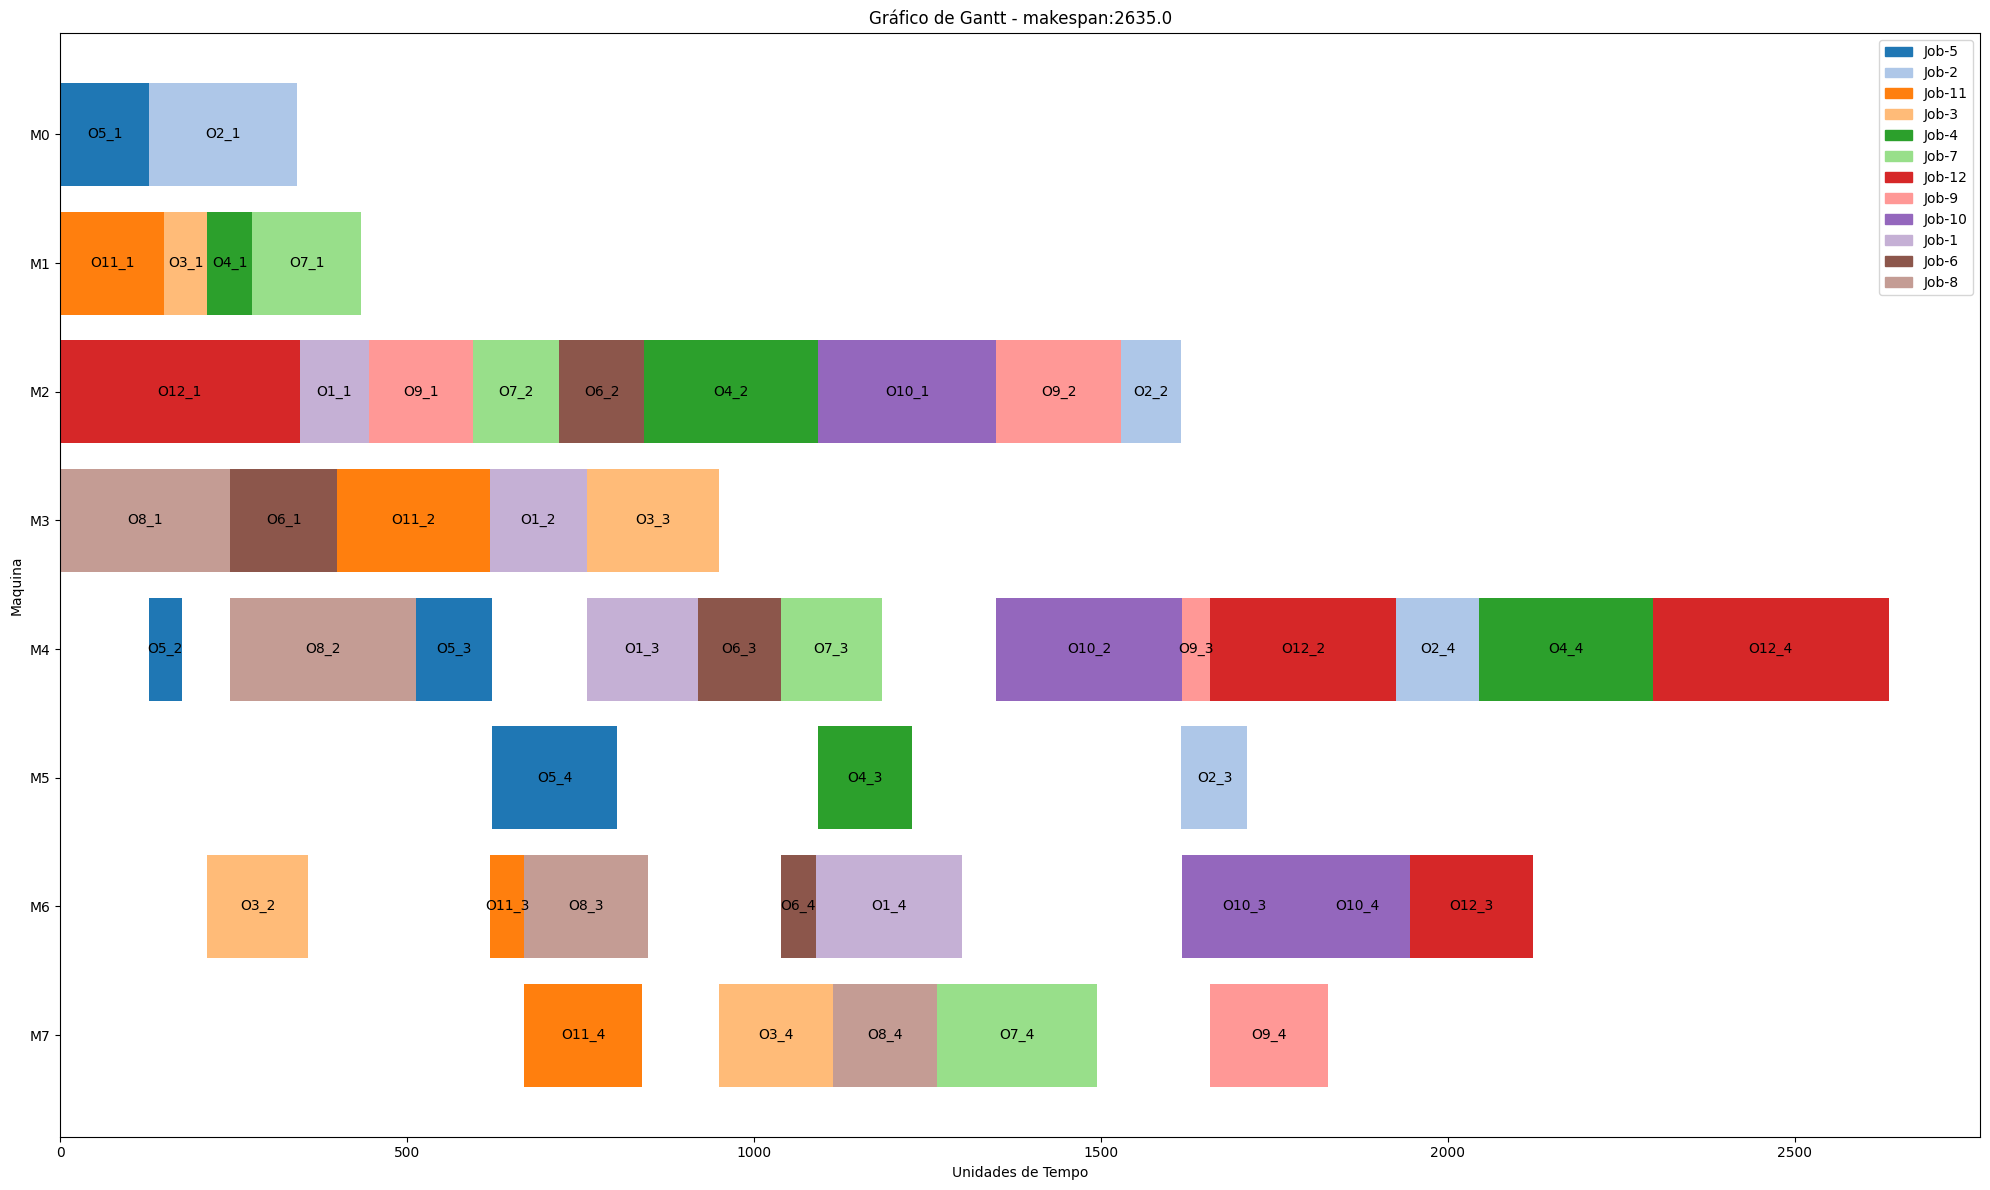

In [48]:
aux, score = pipeline_fjsp.run(dt_times, 
                               c1.OS,
                                 c1.MS, 
                                 verbose=False, 
                                 plot=True)

# Creating a population

In [31]:
machines = dt_times.columns[dt_times.columns.str.startswith('M')].tolist()
pop = genetic_fjsp.Population(dt_times, machines, Popsize=40)

In [32]:
pop.init_pop()

100%|██████████| 40/40 [00:04<00:00,  8.91it/s]


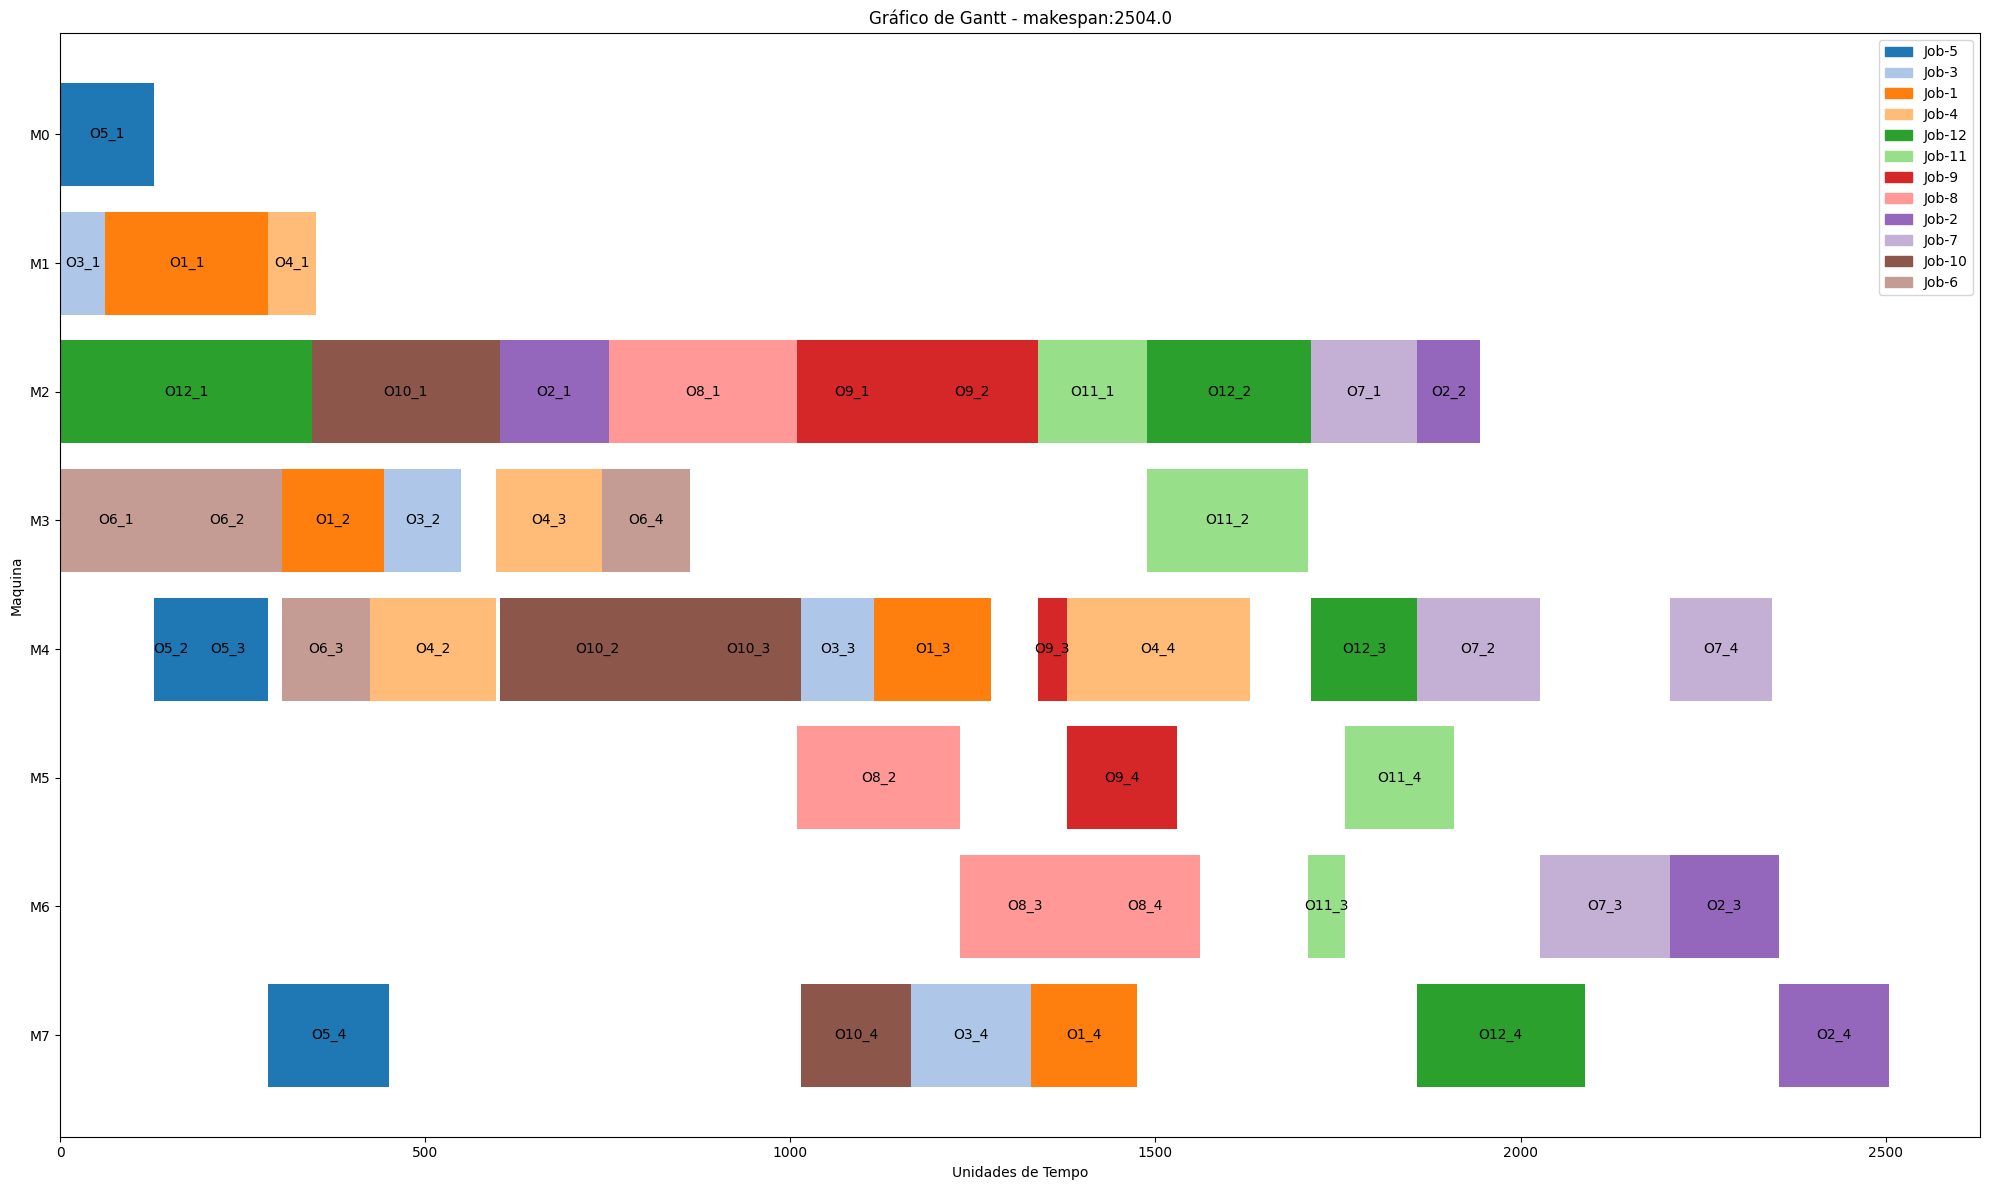

In [34]:
pop.selection()[0].show_output()

In [58]:
machines = dt_times.columns[dt_times.columns.str.startswith('M')].tolist()
pop = genetic_fjsp.Population(dt_times, machines, Popsize=200, maxGen=10)

In [59]:
aux = pop.pipeline_generation()

100%|██████████| 200/200 [00:16<00:00, 11.93it/s]


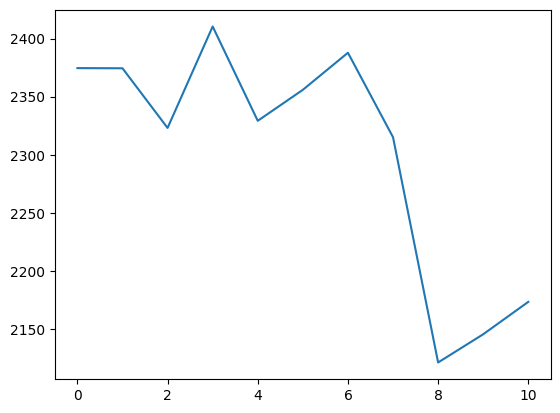

In [60]:
plt.plot(pop.time_series_scores)

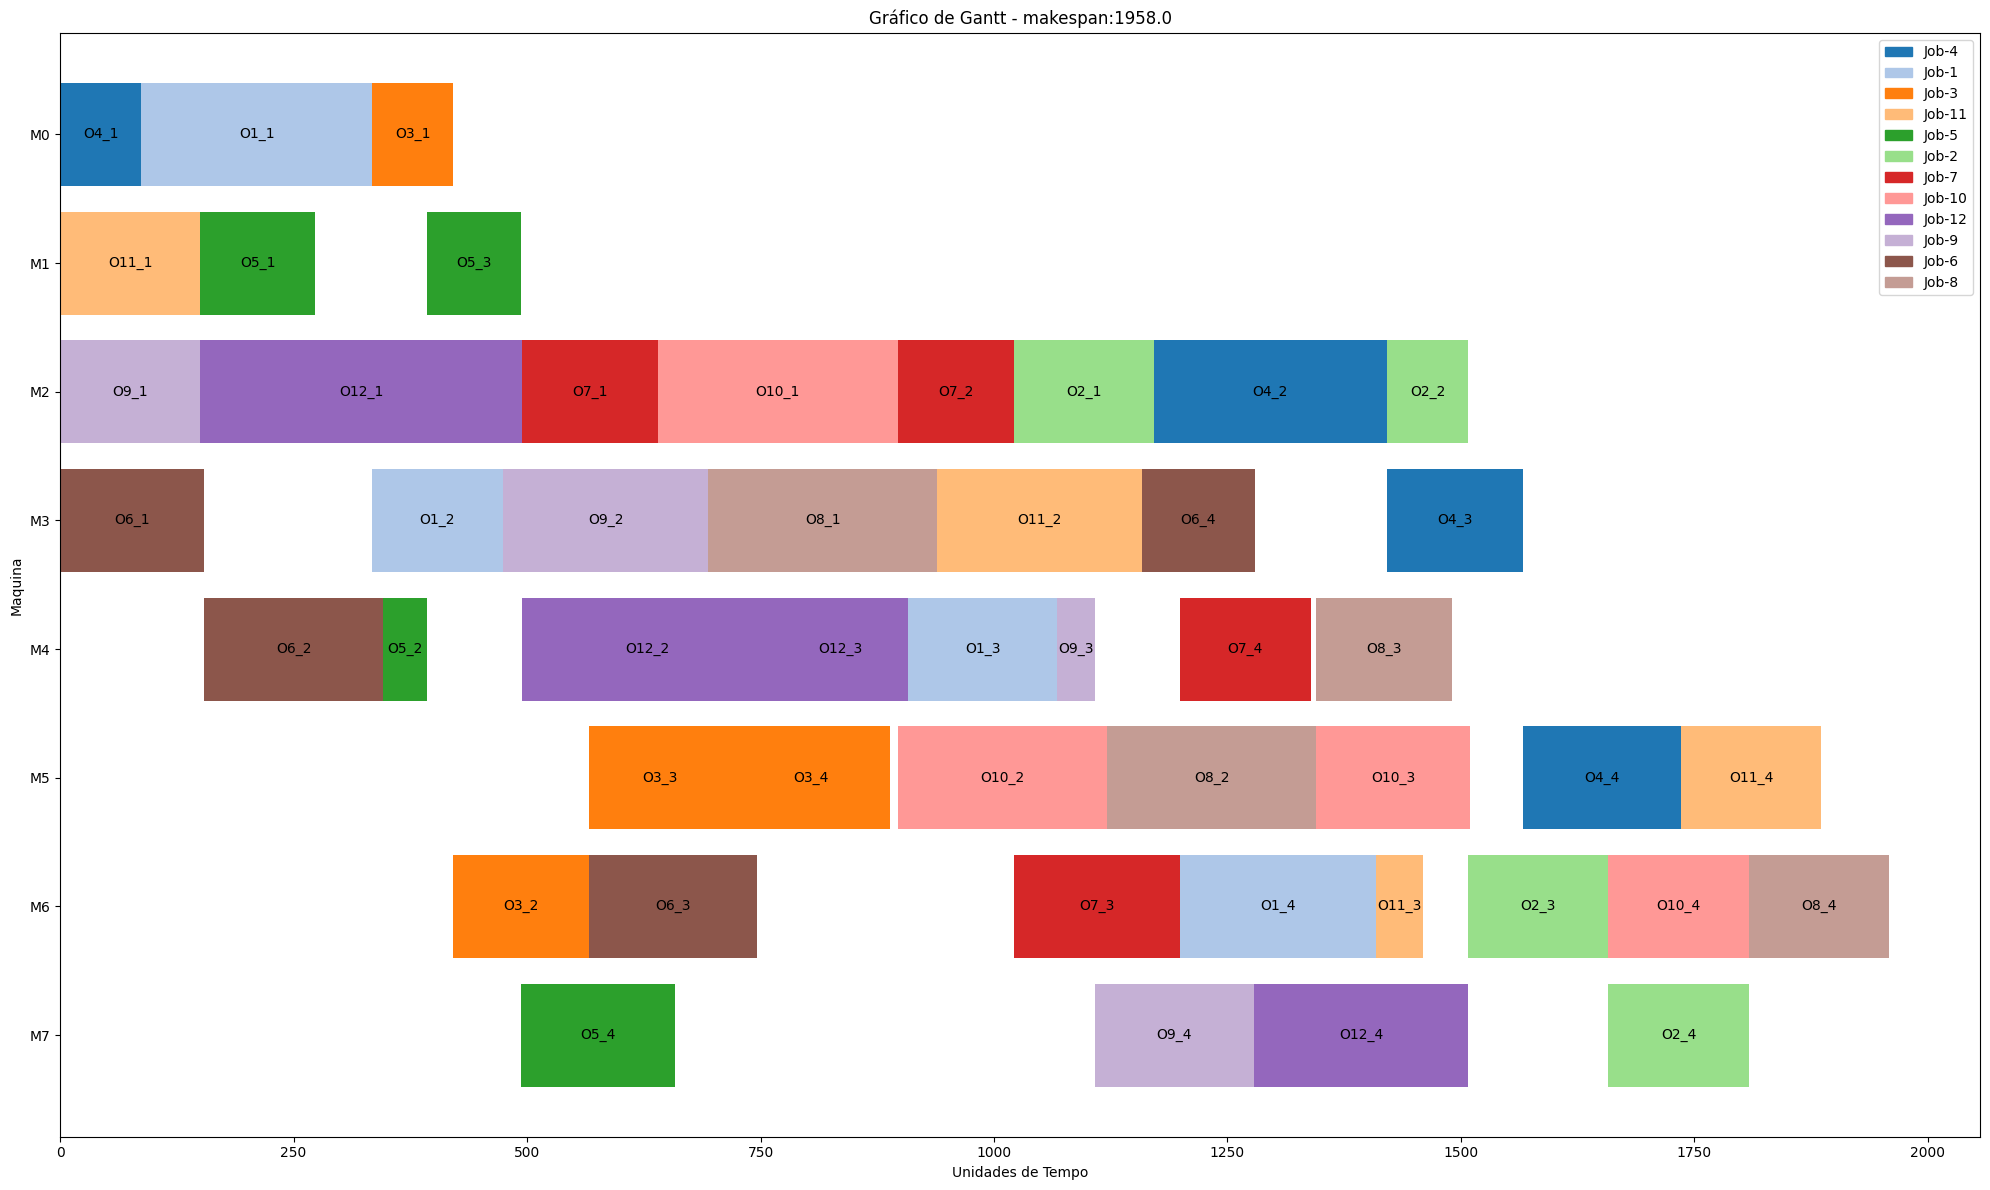

In [61]:
pop.selection()[0].show_output()